# Using a Logistic Regression Classifier to Predict Diabetes

The objective of this program is to employ a logistic regression clasifier on the Pima Indians Diabetes dataset (available from Kaggle) to predict whether or not a patient has diabetes. Features in the dataset include the number of past pregnancies, BMI, diastolic blood pressure and diabetes pedigree function (dpf). 

We begin by reading the data into a Pandas dataframe, checking for missing values and assigning the features to X and the target variable to y.

In [54]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# read in data to Pandas data frame
df = pd.read_csv('diabetes.csv')
# shuffle data before use with sklearn
df = shuffle(df)

# check if there are any missing entries in the data
print(df.isnull().sum())

# assign features and target variable
X = df.drop('diabetes', axis = 1)
y = df['diabetes'].values

X.head(10)

pregnancies    0
glucose        0
diastolic      0
triceps        0
insulin        0
bmi            0
dpf            0
age            0
diabetes       0
dtype: int64


,pregnancies,glucose,diastolic,triceps,insulin,bmi,dpf,age
171,6,134,70,23,130,35.4,0.542,29
663,9,145,80,46,130,37.9,0.637,40
610,3,106,54,21,158,30.9,0.292,24
249,1,111,86,19,0,30.1,0.143,23
474,4,114,64,0,0,28.9,0.126,24
746,1,147,94,41,0,49.3,0.358,27
315,2,112,68,22,94,34.1,0.315,26
128,1,117,88,24,145,34.5,0.403,40
346,1,139,46,19,83,28.7,0.654,22
65,5,99,74,27,0,29.0,0.203,32


There are no missing values in the data but there are suspect zeroes in columns we would not expect to find them in, such as diastolic blood pressure and triceps skinfold thickness. This dataset isn't large enough for us to remove all rows with these zeroes in, so we will replace the values with the mean of the column. This is known as imputation. This method isn't perfect, especially with so many 'missing' values in such a small dataset. However, it is the best we can do here.

In [55]:
# select columns for imputing the mean. I'm assuming that the pregancy feature is the only one where a zero is valid
cols = X.drop('pregnancies', axis = 1).columns

# for each of these columns...
for col in cols:
    # calculate the mean
    mean = X[col].mean()
    # replace any zeroes with the mean
    X[col].replace(0, mean, inplace = True)
X.head(10)

,pregnancies,glucose,diastolic,triceps,insulin,bmi,dpf,age
171,6,134.0,70.0,23.000000,130.000000,35.4,0.542,29
663,9,145.0,80.0,46.000000,130.000000,37.9,0.637,40
610,3,106.0,54.0,21.000000,158.000000,30.9,0.292,24
249,1,111.0,86.0,19.000000,79.799479,30.1,0.143,23
474,4,114.0,64.0,20.536458,79.799479,28.9,0.126,24
746,1,147.0,94.0,41.000000,79.799479,49.3,0.358,27
315,2,112.0,68.0,22.000000,94.000000,34.1,0.315,26
128,1,117.0,88.0,24.000000,145.000000,34.5,0.403,40
346,1,139.0,46.0,19.000000,83.000000,28.7,0.654,22
65,5,99.0,74.0,27.000000,79.799479,29.0,0.203,32


We can generate a correlation matrix of the variables to identify which features in the data correlate most strongly with the target variable (diabetes).

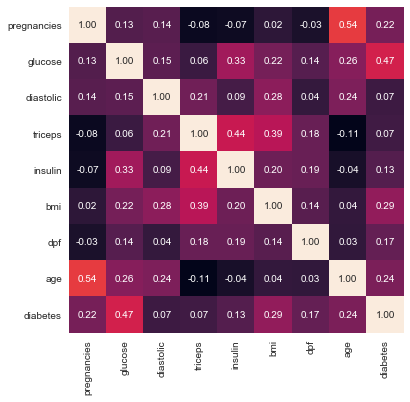

In [56]:
# generate plot of correlation matrix of the variables
corr_matrix = df.corr()
fig = plt.figure(figsize = (6, 6))
sns.heatmap(corr_matrix, annot = True, fmt = '.2f', cbar = False)
plt.show()

The feature most strongly correlated with diabetes is blood glucose.

The data in the different columns of X varies by orders of magnitude. We are going to be using regularisation so it is important that the data is scaled. For this we use StandardScaler which returns the z-score of a sample.

In [57]:
# scale data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

First we will see how the model performs without regularisation, before comparing to a regularised model.

In [58]:
# create the logistic regression classifier
log_reg = LogisticRegression(solver='liblinear', C = 1e5)
# instantiate the GridSearch object
log_reg_cv = cross_val_score(log_reg, X_scaled, y, cv = 5)
print('Mean cross-validation score: {:.3f}'.format(np.mean(log_reg_cv)))

Mean cross-validation score: 0.767


In sklearn a logistic regression classifier can take two regularisation types, ridge (L2) or lasso (L1). The elastic net penalty is a linear combination of ridge and lasso types. Sklearn uses the regularisation hyperparameter $C=\frac{1}{\alpha}$, where $\alpha$ is the regularisation hyperparameter found in the regularised logistic regression cost function. If we create a grid of possible $C$ values, we can perform a cross-validated grid search to find the optimal value of $C$ for our model. We can also identify the optimal penalty type.

In [59]:
# setup the hyperparameter grid
c_space = np.logspace(-2, 3, 20)
param_grid = {'C': c_space, 'penalty': ['l1', 'l2']}
# generate classifier
log_reg2 = LogisticRegression(solver = 'liblinear')
# perform cross-validated grid search
log_reg_cv = GridSearchCV(log_reg2, param_grid, cv = 5)
log_reg_cv.fit(X_scaled, y)
print('Tuned Logistic Regression Parameter: {}'.format(log_reg_cv.best_params_))
print('Tuned Logistic Regression Accuracy: {:.3f}'.format(log_reg_cv.best_score_))

Tuned Logistic Regression Parameter: {'C': 0.03359818286283781, 'penalty': 'l2'}
Tuned Logistic Regression Accuracy: 0.777


The cross-validated grid search chooses ridge regression and an associated $C$ value for optimal model performance. However, we can see from the cross-validated accuracy score that model performance is only marginally better than in the unregularised case. 

Another useful tool for evaluating a logistic regression classifier is the Receiver Operating Characteristic (ROC) curve, which is a plot of the true positive rate vs false positive rate as the hypothesis function threshold is varied. The Area Under the Curve (AUC) score gives a general indication of model performance.

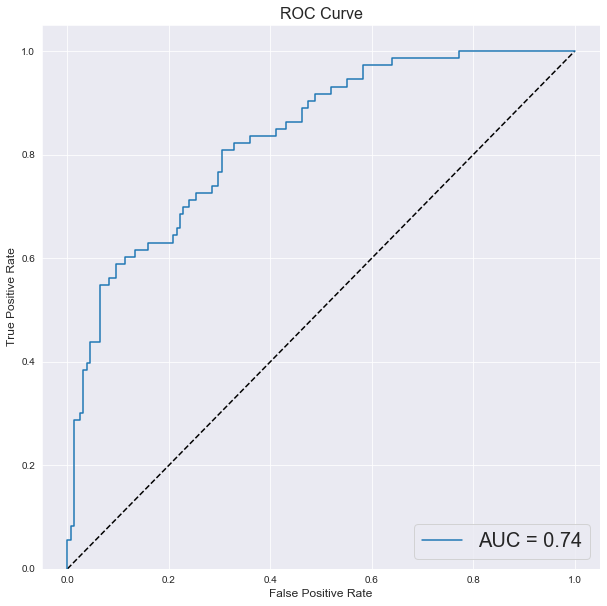

In [60]:
# create optimal classifier from tuned hyperparameters
log_reg_optimal = log_reg_cv.best_estimator_

# generate training and testing sets 
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size = 0.3,
                                   random_state = 42)

# train classifier 
log_reg_optimal.fit(X_train, y_train)
# make predictions on test set
y_pred = log_reg_optimal.predict(X_test)

# generate plot
sns.set_style('darkgrid')
fig = plt.figure(figsize = (10, 10))
ax = fig.add_subplot(111)
ax.plot([0, 1], [0, 1], 'k--')
ax.set_xlabel('False Positive Rate', fontsize = 12)
ax.set_ylabel('True Positive Rate', fontsize = 12)
ax.set_title('ROC Curve', fontsize = 16)
ax.set_ylim(0,)

# plot ROC curve
# get probabilities that y_test is predicted 1
y_pred_prob = log_reg_optimal.predict_proba(X_test)[:,1]
# get false positive and true positive rates
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
# compute area under curve score
auc_score = roc_auc_score(y_test, y_pred)
# plot ROC curve on ax
ax.plot(fpr, tpr, label = 'AUC = {:.2f}'.format(auc_score))
plt.legend(loc = 'lower right', prop = {'size': 20})
plt.show()

The relative magnitudes of the coefficients can give us a rough idea of the predictive power of the features in a logistic regression model.

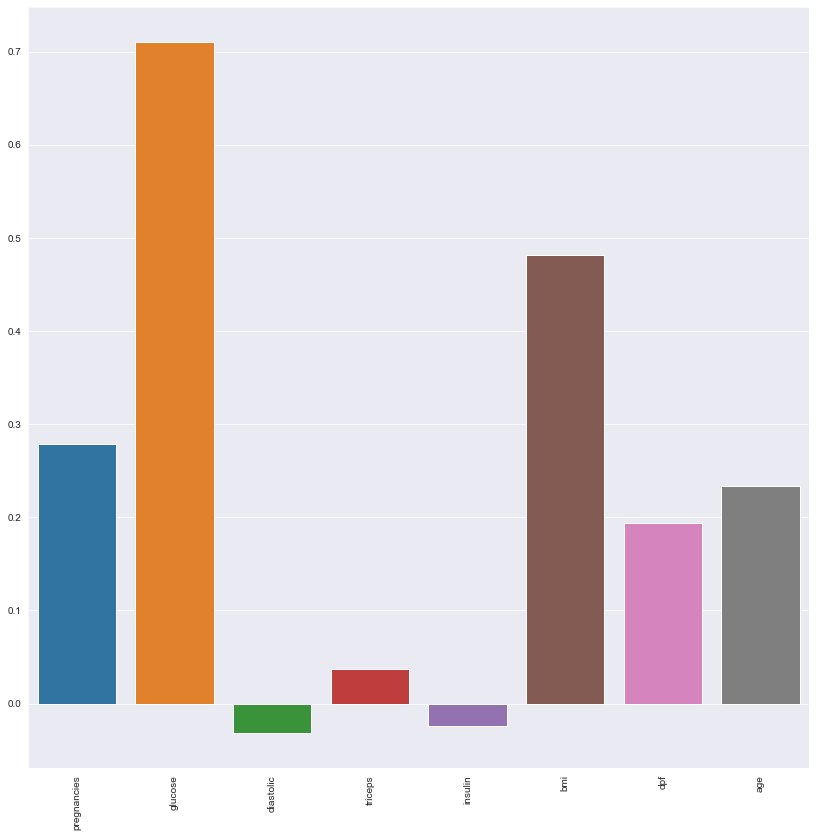

In [61]:
# get coefficients and plot
coeffs = log_reg_optimal.coef_[0]
plt.figure(figsize = (14, 14))
bar_names = X.columns
sns.barplot(bar_names, coeffs)
plt.xticks(rotation = 90)
plt.show()

Blood glucose and bmi appear to be the features with the greatest predictive power in the model. These are the two features that we saw were most highly correlated with the diabetes variable earlier. 